In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data as pd
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/Single_joint_trial

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1258, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (357/357), done.
remote: Total 1258 (delta 524), reused 476 (delta 343), pack-reused 557 (from 1)
Receiving objects: 100% (1258/1258), 12.73 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (837/837), done.
/content/Real_Mega_Fufi/Robot/Single_joint_trial


In [44]:
#connecting
p.connect(p.DIRECT)

# using FEM
p.resetSimulation(p.RESET_USE_DEFORMABLE_WORLD)
#set sampling time
p.setGravity(0, 0, -9.81)
# set sampling time: if too high it becomes instable
#p.setTimeStep(0.0001)
#p.setPhysicsEngineParameter(numSolverIterations=2000)
# Aggiungi il percorso dei dati PyBullet for the plane
p.setAdditionalSearchPath(pd.getDataPath())

useFixedBase_flag = True
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=useFixedBase_flag)

elastic_joint_id = p.loadSoftBody("elastic_joint_center_less_vertex.obj",
                                  scale = 1,
                                  mass = 0.0569,
                                  #collisionMargin = 0.001,
                                  #useMassSpring = 1,
                                  #useBendingSprings = 0,
                                  useNeoHookean = 1,

                                  springElasticStiffness = 300e9,
                                  springDampingStiffness = 30e9,
                                  springBendingStiffness= 300e9,

                                  springDampingAllDirections = 1 ,


                                  NeoHookeanMu = 76.92e9,  # Shear modulus (calculated)
                                  NeoHookeanLambda= 115.38e9,  # First Lamé parameter (calculated)

                                  NeoHookeanDamping = 0.07,
                                  #frictionCoeff = 0.5,
                                  #useFaceContact = 1,
                                  useSelfCollision = 0,
                                  #repulsionStiffness = 0.1
                                )
#arancione
p.changeVisualShape(elastic_joint_id, -1, rgbaColor=[1, 0.65, 0, 1])


```
pybullet.loadSoftBody(
    fileName,                       # string (path to .obj file)
    basePosition=None,              # list of 3 floats, e.g., [x, y, z]
    baseOrientation=None,           # list of 4 floats (quaternion), e.g., [x, y, z, w]
    scale=1.0,                      # float (scaling factor)
    mass=1.0,                       # float (total mass of the soft body)
    useNeoHookean=0,                # int, 1=Neo-Hookean model, 0=disable
    useBendingSprings=0,            # int, 1=enable bending springs, 0=disable
    useMassSpring=1,                # int, 1=use mass-spring model, 0=disable
    springElasticStiffness=1.0,     # float (elastic stiffness of springs)
    springDampingStiffness=0.1,     # float (damping stiffness of springs)
    springDampingAllDirections=0,   # int, 1=damping in all directions, 0=default
    useSelfCollision=0,             # int, 1=enable self-collision, 0=disable
    frictionCoeff=0.5,              # float (friction coefficient)
    collisionMargin=0.001,          # float (collision margin)
    repulsionStiffness=0.1,         # float (repulsion stiffness for collisions)
    useFaceContact=0,               # int, 1=use face contact for collisions, 0=disable
    simulateClusterStiffness=1.0,   # float, stiffness for clusters (if clusters used)
    simulateClusterVolumeStiffness=1.0  # float, volume stiffness for clusters
)


```





In [45]:
# Recupera le posizioni dei nodi del soft body
mesh_data = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)
if mesh_data:
    num_nodes = mesh_data[0]  # Numero di nodi
    node_positions = mesh_data[1]  # Posizioni dei nodi

    # Identifica i limiti superiore e inferiore di z
    z_values = [pos[2] for pos in node_positions]
    max_z = max(z_values)
    min_z = min(z_values)
    tolerance = 0.0001  # Definisce una soglia di tolleranza

    # Ancoraggio dei nodi alle facce superiore e inferiore
    for node_index, node_pos in enumerate(node_positions):
        if abs(node_pos[2] - min_z) <= tolerance:
            # Nodo inferiore: ancora alla colonna
            p.createSoftBodyAnchor(elastic_joint_id, node_index, plane, -1)
            #print("indice down:", node_index)

else:
    print("Errore: I dati della mesh non sono stati recuperati correttamente.")

In [46]:

# Parametri della fotocamera
cam_target_pos = [0, 0, 0.01]
cam_distance = 0.3
cam_yaw, cam_pitch, cam_roll = 0, 0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto



In [47]:
joint_positions_x, joint_positions_y, joint_position_z = [], [], []
joint_positions_down_z, joint_positions_up_z = [], []

In [48]:
# Ciclo principale della simulazione
for step in range(300):
    #get joint position
    joint_position, joint_orientation = p.getBasePositionAndOrientation(elastic_joint_id)
    joint_positions_x.append(joint_position[0])
    joint_positions_y.append(joint_position[1])
    joint_position_z.append(joint_position[2])

    #get joint vertex positions
    mesh_data = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)
    node_positions = mesh_data[1]  # Posizioni dei nodi
    joint_positions_down_z.append(node_positions[0][2])
    joint_positions_up_z.append(node_positions[1][2])

    # Aggiorna il video
    # Calcola la vista e la proiezione della fotocamera
    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
        cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
    )
    cam_projection_matrix = p.computeProjectionMatrixFOV(
        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
    )

    # Cattura l'immagine
    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

    # Scrivi il fotogramma nel video
    vid.send(np.ascontiguousarray(image))

    p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
vid.close()


In [49]:
# Disconnessione dalla simulazione
p.disconnect()
# Leggi il file video
mp4 = open('simulation_output.mp4', 'rb').read()

# Convertilo in Base64
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Visualizza il video nel notebook Jupyter
HTML(f'<video width="600" controls><source src="{data_url}" type="video/mp4"></video>')

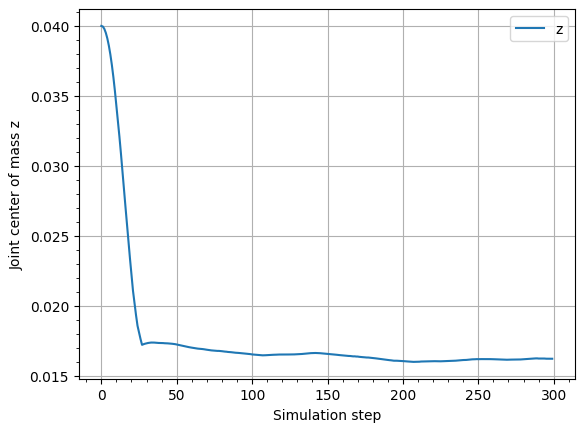

In [50]:
plt.figure()
plt.plot(joint_position_z, label = 'z')
plt.xlabel('Simulation step')
plt.ylabel('Joint center of mass z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

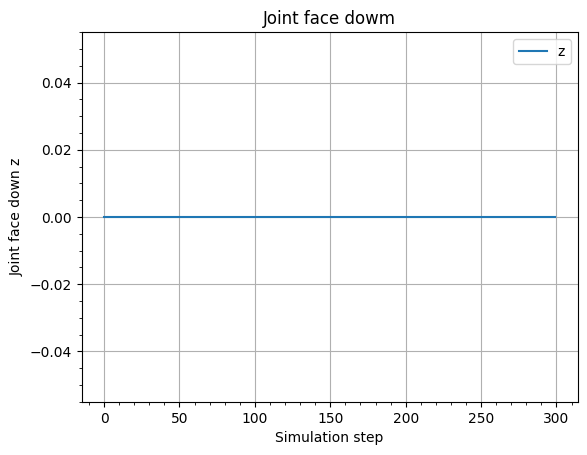

In [51]:
plt.figure()
plt.title("Joint face dowm")
plt.plot(joint_positions_down_z, label = 'z')
plt.xlabel('Simulation step')
plt.ylabel('Joint face down z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

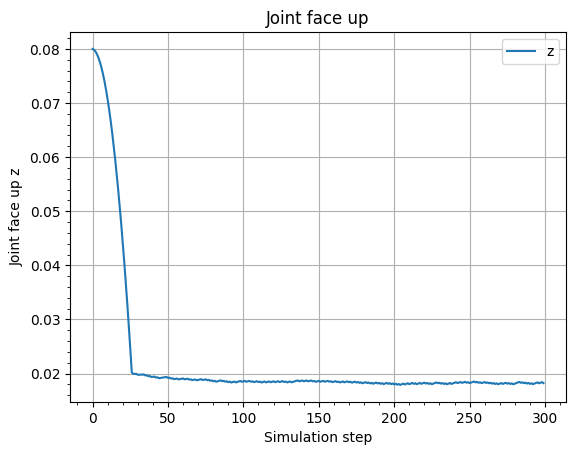

In [52]:
plt.figure()
plt.title("Joint face up")
plt.plot(joint_positions_up_z, label = 'z')
plt.xlabel('Simulation step')
plt.ylabel('Joint face up z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()